In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [4]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import pathlib
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import *
from keras.layers import *
from tensorflow.keras.optimizers import Adam
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.activations import *

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install openpyxl

In [3]:
!pip install natsort
import natsort

In [ ]:
covid_info='/content/drive/MyDrive/mm/COVID.metadata.xlsx'

In [ ]:
import pandas as pd
import openpyxl
excel = openpyxl.load_workbook(covid_info)
sheet = excel.active

In [ ]:
sheet

<Worksheet "Sheet1">

In [ ]:
for row in sheet.iter_rows(max_row=10):
    for cell in row:
        print(cell.value, end=" ")
    print()

FILE NAME FORMAT SIZE URL 
COVID-1 PNG 256*256 https://sirm.org/category/senza-categoria/covid-19/ 
COVID-2 PNG 256*256 https://sirm.org/category/senza-categoria/covid-19/ 
COVID-3 PNG 256*256 https://sirm.org/category/senza-categoria/covid-19/ 
COVID-4 PNG 256*256 https://sirm.org/category/senza-categoria/covid-19/ 
COVID-5 PNG 256*256 https://sirm.org/category/senza-categoria/covid-19/ 
COVID-6 PNG 256*256 https://sirm.org/category/senza-categoria/covid-19/ 
COVID-7 PNG 256*256 https://sirm.org/category/senza-categoria/covid-19/ 
COVID-8 PNG 256*256 https://sirm.org/category/senza-categoria/covid-19/ 
COVID-9 PNG 256*256 https://sirm.org/category/senza-categoria/covid-19/ 


In [5]:
images_dir_path='/content/drive/MyDrive/mm/shenzhen/img'
masks_dir_path='/content/drive/MyDrive/mm/shenzhen/mask'

images_dir=os.listdir(images_dir_path)
masks_dir=os.listdir(masks_dir_path)

print("="*32+"\nTotal number of Images : ",len(images_dir))
print("="*32+"\nTotal number of Masks : ",len(masks_dir))

Total number of Images :  566
Total number of Masks :  566


In [6]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [7]:
images_dir = natsort.natsorted(images_dir)
masks_dir = natsort.natsorted(masks_dir)

images_path=[]

for i in range(len(images_dir)):
    temp_path=os.path.join(images_dir_path, images_dir[i])
    images_path.append(temp_path)

masks_path=[]

for i in range(len(masks_dir)):
    temp_mask=os.path.join(masks_dir_path, masks_dir[i])
    masks_path.append(temp_mask)

In [8]:
print(images_path[0]+"\n"+masks_path[0])

/content/drive/MyDrive/mm/shenzhen/img/CHNCXR_0001_0.png
/content/drive/MyDrive/mm/shenzhen/mask/CHNCXR_0001_0.png


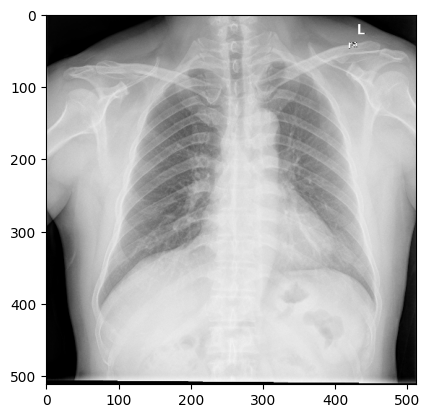

In [9]:
plt.imshow(plt.imread(images_path[0]))

In [10]:
img_row = 512
img_col = 512
img_chan = 3
target_shape = (img_row, img_col, img_chan)
num_imgs=len(images_path)

images=np.zeros((num_imgs, img_row, img_col))
masks=np.zeros_like(images)

In [11]:
def load_imgs_masks(DIR, array):

    for i in range(len(DIR)):
        temp_img=image.load_img(DIR[i], target_size=target_shape)
        img=image.img_to_array(temp_img)
        array[i]=img[:,:,0]/255.0

    array=np.expand_dims(array, axis=3)
    return array

In [12]:
images=load_imgs_masks(images_path, images)
masks=load_imgs_masks(masks_path, masks)

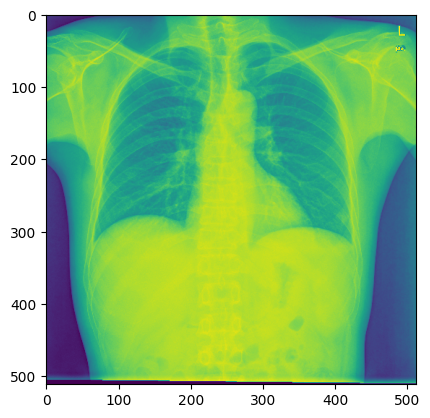

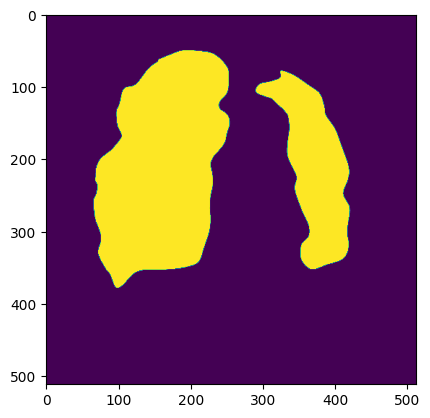

In [13]:
plt.imshow(images[np.random.randint(0,1000)])
plt.show()
plt.imshow(masks[np.random.randint(0,1000)])
plt.show()

In [14]:
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.3, random_state=SEED)

# MODEL TRAINING

In [15]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [16]:
def build_model(start_neurons):

    input_layer = Input((512, 512, 1))

    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

    model=Model(inputs=input_layer, outputs=output_layer)

    return model

In [17]:
model=build_model(16)

In [18]:
EPOCHS = 15
model.compile(optimizer=Adam(learning_rate=5*1e-4), loss="binary_crossentropy",
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 16)         160       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

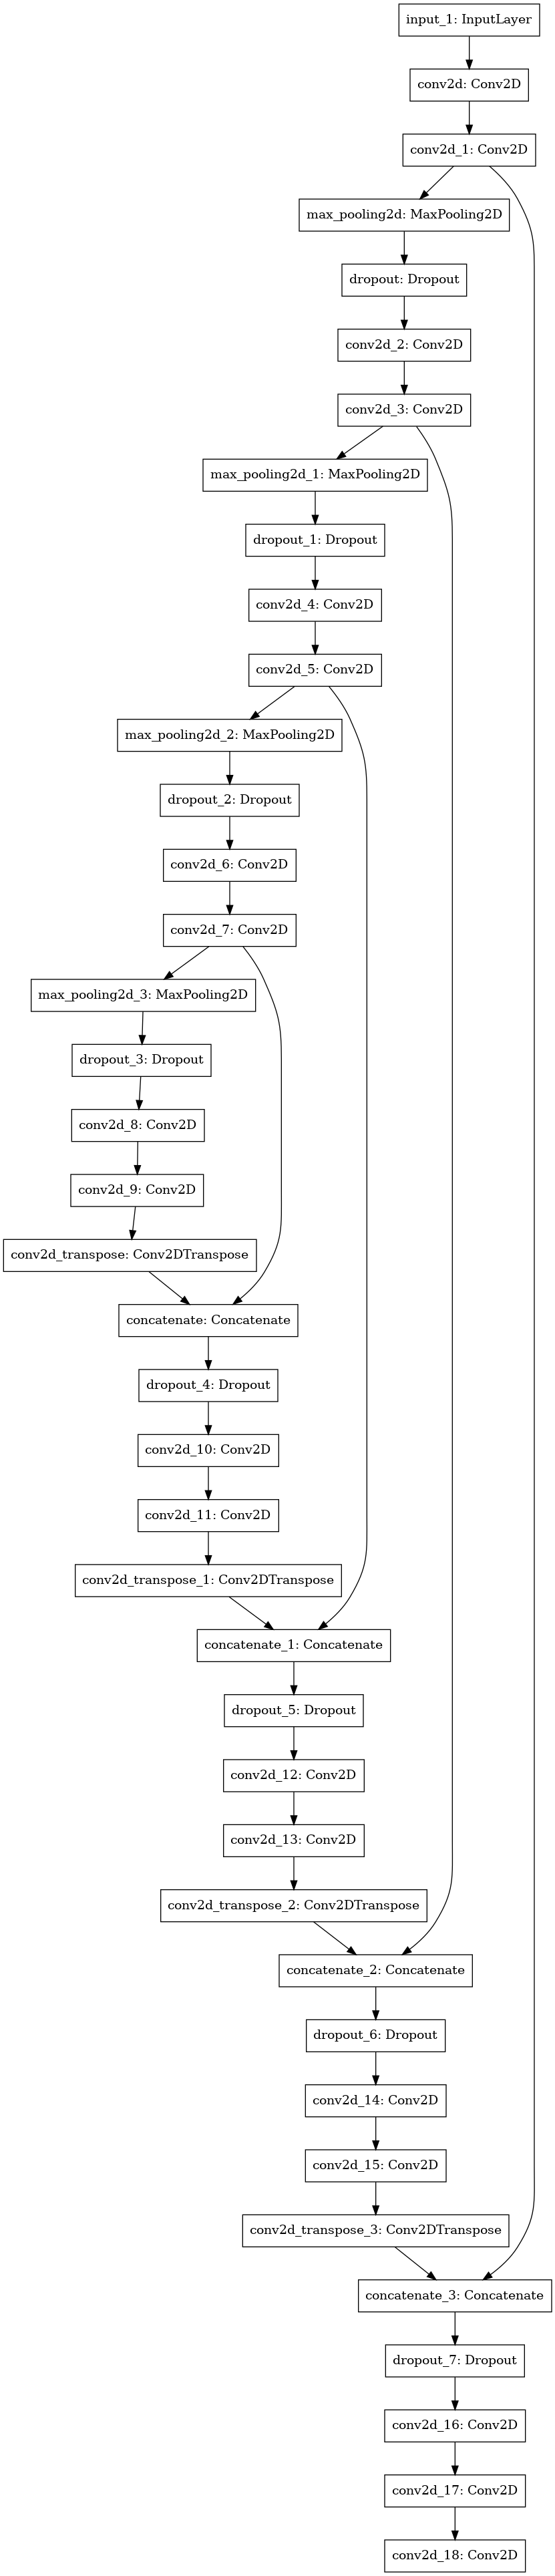

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png')

In [19]:
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='loss', #verbose=1,
                             save_best_only=True, #mode='min',
                             save_weights_only = True)


early = EarlyStopping(monitor="loss",
                      #mode="min",
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early]
#earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [24]:
curr_time=datetime.now()
print("Starting time : ", datetime.now())
history = model.fit(x = train_images,
                    y = train_masks,
                    validation_data = (test_images, test_masks),
                    epochs = 20,
                    batch_size = 16,
                   callbacks = callbacks_list)
time_now=datetime.now()
print("Ending time : ", time_now)
print("="*40+"Time taken : ", time_now-curr_time)
model.save('my_model.h5')

Starting time :  2024-07-22 19:32:58.382918
Epoch 1/20
25/25 [==============================] - 23s 931ms/step - loss: 0.0950 - dice_coef: 0.8950 - binary_accuracy: 0.9647 - val_loss: 1.6425 - val_dice_coef: 0.5899 - val_binary_accuracy: 0.6591
Epoch 2/20
25/25 [==============================] - 22s 893ms/step - loss: 0.0897 - dice_coef: 0.9009 - binary_accuracy: 0.9665 - val_loss: 1.4884 - val_dice_coef: 0.6058 - val_binary_accuracy: 0.6815
Epoch 3/20
25/25 [==============================] - 22s 866ms/step - loss: 0.0851 - dice_coef: 0.9053 - binary_accuracy: 0.9680 - val_loss: 1.6762 - val_dice_coef: 0.5904 - val_binary_accuracy: 0.6604
Epoch 4/20
25/25 [==============================] - 22s 868ms/step - loss: 0.0787 - dice_coef: 0.9129 - binary_accuracy: 0.9705 - val_loss: 1.2557 - val_dice_coef: 0.6267 - val_binary_accuracy: 0.7090
Epoch 5/20
25/25 [==============================] - 22s 879ms/step - loss: 0.0784 - dice_coef: 0.9136 - binary_accuracy: 0.9703 - val_loss: 1.1891 - val

In [25]:
model.evaluate(test_images, test_masks)

6/6 [==============================] - 2s 276ms/step - loss: 0.1439 - dice_coef: 0.8742 - binary_accuracy: 0.9506


[0.14387299120426178, 0.8742343783378601, 0.950560450553894]

1/1 [==============================] - 3s 3s/step


0.8772698389177618

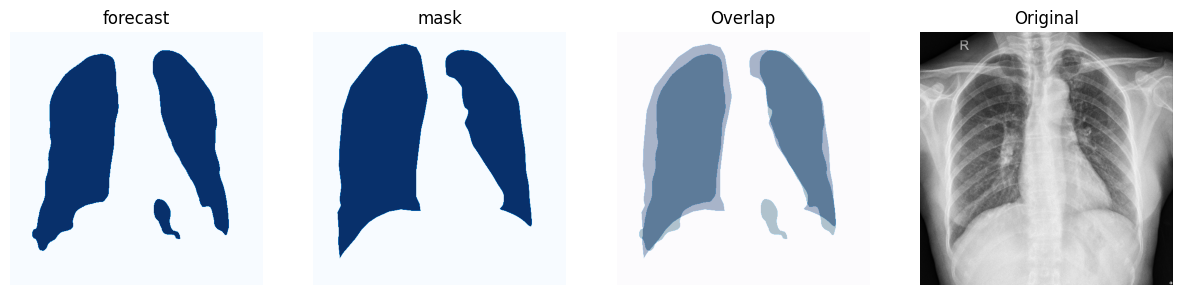

In [26]:
def test_on_image(model, img_array, img_num, img_side_size = 512):

    pred = model.predict(img_array[img_num].reshape(1,img_side_size,img_side_size,1))
    pred[pred>0.5] = 1.0
    pred[pred<0.5] = 0.0
    fig = plt.figure(figsize = (15,10))

    plt.subplot(1,4,1)
    plt.imshow(pred.reshape(img_side_size, img_side_size), cmap = "Blues")
    plt.title("forecast")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(test_masks[img_num].reshape(img_side_size, img_side_size), cmap = "Blues")
    plt.title("mask");
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(test_masks[img_num].reshape(img_side_size, img_side_size), cmap = "Blues", alpha = 0.5)
    plt.imshow(pred.reshape(img_side_size, img_side_size),cmap = "PuBu", alpha = 0.3)
    plt.title("Overlap")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(img_array[img_num].reshape(img_side_size, img_side_size), cmap = "gray")
    plt.title("Original")
    plt.axis("off")

    return pred

def dice_coef_test(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

IMG_NUM = 3 #Melhor img_num 12 (0.98) Pior img_num 10 (0.9)
prediction = test_on_image(model, img_array = test_images, img_num = IMG_NUM, img_side_size = 512)
dice_coef_test(y_true = test_masks[IMG_NUM], y_pred = prediction)

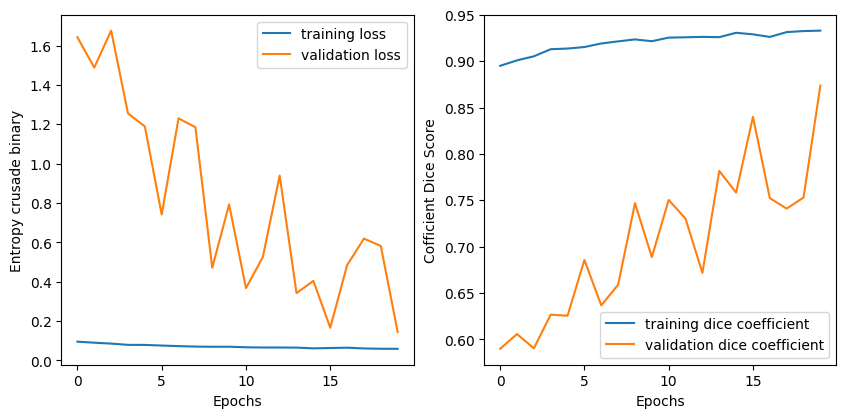

In [27]:
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["loss"], label = "training loss")
    plt.plot(history.history["val_loss"], label = "validation loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Entropy crusade binary")

    plt.subplot(2,2,2)
    plt.plot(history.history["dice_coef"], label = "training dice coefficient")
    plt.plot(history.history["val_dice_coef"], label = "validation dice coefficient")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Cofficient Dice Score")

get_metrics(history = history)

In [28]:
history.history.keys()

dict_keys(['loss', 'dice_coef', 'binary_accuracy', 'val_loss', 'val_dice_coef', 'val_binary_accuracy'])